# Convolutional Neural Network image classification and tuning

In this project, I use convolutional neural networks (CNNs) to classify flower images from the `tf_flowers` dataset.  
First, I preprocess the data and build a simple custom CNN model trained from scratch.  
Then, I apply transfer learning using the pre-trained Xception model as a feature extractor.  
Both models are trained and evaluated on separate training, validation, and test sets.  
Finally, I compare their performance and save the trained models along with accuracy metrics.

We load the `tf_flowers` image classification dataset and manually split it into three subsets:
- **10%** for the test set (`test_set_raw`)
- **15%** for the validation set (`valid_set_raw`)
- **75%** for the training set (`train_set_raw`)

We also enable supervised mode (returning image-label pairs) and request dataset metadata via `with_info=True`.

In [ ]:
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load("tf_flowers", split=['train[:10%]', "train[10%:25%]", "train[25%:]"], as_supervised=True, with_info=True)

From the `info` object returned by `tfds.load`, we extract:
- `class_names`: list of class labels (e.g., 'daisy', 'roses', ...)
- `n_classes`: total number of classes
- `dataset_size`: total number of images in the dataset before splitting

This information will be used to define the model output and for label display during visualization.

In [ ]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

We display 9 sample images from the training set (`train_set_raw`) along with their corresponding class labels.  
Each image is shown in a 3×3 grid using `matplotlib`, and the class name is displayed above each image.

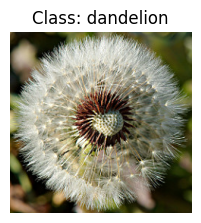

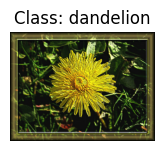

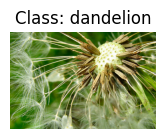

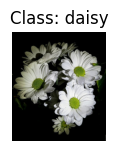

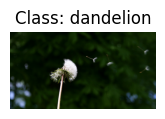

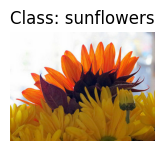

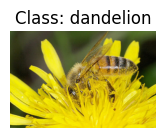

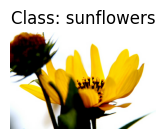

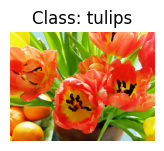

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title("Class: {}".format(class_names[label]))
  plt.axis("off")
  plt.show(block=False)


## 1. Data preparation

This function resizes each image to 224×224 pixels, which matches the expected input shape for our CNN model.  
Labels remain unchanged. This preprocessing will be applied to every image in the dataset.

In [ ]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  return resized_image, label


Here we apply the `preprocess` function to all raw datasets using `.map(...)`.  
For the training set, we shuffle the data using the full dataset size to ensure randomness across epochs.  
All datasets are batched into mini-batches of size 32, which allows efficient parallel training.  
`.prefetch(1)` is used to prepare the next batch in the background while the current one is being processed.  
The result is three optimized datasets: one for training, one for validation, and one for testing.  
These are ready to be passed into the `fit()` function of the model.

In [ ]:
import tensorflow as tf

batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


We take the first batch from the training set and display 12 images along with their class names.  
Each image is normalized by dividing by 255.0 for display purposes. (so that pixels are on scale 0.0 - 1.0)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


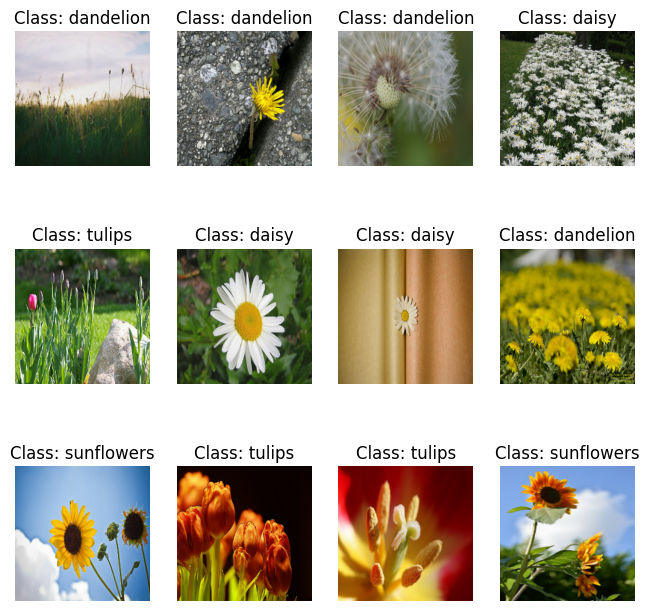

In [ ]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch:
  for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(X_batch[index]/255.0)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()


## 2. Building a CNN neural network from sratch

### 🧠 Building a custom CNN model layer by layer

In this CNN architecture, we gradually increase the number of filters while decreasing the kernel size.  
This reflects how early layers detect general patterns (like edges or textures), and deeper layers focus on more complex shapes and object parts.

- **Rescaling layer**  
  Scales pixel values from `[0, 255]` to `[0, 1]`, preparing the input for the network.

- **1st Conv2D layer** – 32 filters, kernel size 7×7  
  A wide filter for detecting broad, low-level features across the image.

- **1st MaxPooling2D** – pool size 2×2  
  Reduces spatial dimensions, making the representation more compact and reducing computation.

- **2nd Conv2D layer** – 64 filters, kernel size 3×3  
  Focuses on finer patterns by analyzing smaller regions, with more filters capturing more detail.

- **2nd MaxPooling2D** – again compresses the feature map.

- **3rd Conv2D layer** – 128 filters, kernel size 3×3  
  The deepest convolutional layer captures high-level, abstract features.

- **3rd MaxPooling2D** – further reduces spatial size for flattening.

- **Flatten**  
  Converts the 3D feature maps into a 1D vector to feed into dense layers.

- **Dense(128) + Dropout(0.5)**  
  A fully connected layer for learning complex feature combinations, with dropout to prevent overfitting.

- **Dense(n_classes, softmax)**  
  Output layer that predicts class probabilities for multi-class classification.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    tf.keras.layers.Conv2D(32, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We configure the model for training by specifying:
- `loss='sparse_categorical_crossentropy'` – suitable for integer-labeled multi-class classification
- `optimizer='adam'` – an adaptive optimizer commonly used for CNNs
- `metrics=['accuracy']` – to monitor classification accuracy during training

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

We train the model using the training set for 10 epochs and validate its performance on the validation set after each epoch.  
This process updates the model's weights based on the training data and reports accuracy metrics for both datasets. (both train and valid)

In [ ]:
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 471s 5s/step - accuracy: 0.2693 - loss: 2.0795 - val_accuracy: 0.4955 - val_loss: 1.1687
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.4857 - loss: 1.2101 - val_accuracy: 0.5027 - val_loss: 1.1871
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 0.5273 - loss: 1.1370 - val_accuracy: 0.5662 - val_loss: 1.0906
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.6011 - loss: 1.0246 - val_accuracy: 0.5953 - val_loss: 1.0425
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.6355 - loss: 0.9173 - val_accuracy: 0.5753 - val_loss: 1.0748
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.7040 - loss: 0.7766 - val_accuracy: 0.6316 - val_loss: 0.9516
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - accuracy: 0.7588 - loss: 0.6270 - val_accuracy: 0.6407 - val_loss: 0.9959
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.8182 - loss: 0.5154 - val_accuracy: 0.6207 - v

We evaluate the trained model on all three datasets: training, validation, and test.  

In [ ]:
acc_train = model.evaluate(train_set, verbose=0)[1]
acc_valid = model.evaluate(valid_set, verbose=0)[1]
acc_test = model.evaluate(test_set, verbose=0)[1]

We display the final accuracy values for training, validation, and test sets, each rounded to four decimal places.  
This allows us to compare generalization and detect overfitting.

In [ ]:
print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (valid): {acc_valid:.4f}")
print(f"Accuracy (test):  {acc_test:.4f}")

Accuracy (train): 0.9677
Accuracy (valid): 0.6515
Accuracy (test):  0.7084


The final model is saved in Keras format (`.keras`), and the accuracy scores are stored in a `.pkl` file using `pickle`.  
This allows later reuse without retraining and makes it easy to load evaluation results.

In [ ]:
import pickle

with open("simple_cnn_acc.pkl", "wb") as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)

model.save("simple_cnn_flowers.keras")

### ✅ Training summary

The final accuracy results show solid performance for a simple CNN trained from scratch:

- Training accuracy: **96.8%**
- Validation accuracy: **65.1%**
- Test accuracy: **70.8%**

This indicates **slight overfitting** — the model performs very well on the training data, but less so on unseen data.  
However, considering the model's simplicity and the lack of transfer learning, the results are **very promising**.  
This baseline model provides a strong starting point for comparison with more advanced architectures.

## 3. Building CNN neural network with transfer learning (using already trained layers form different models)

Each image is resized to 224×224 pixels and then preprocessed using `xception.preprocess_input`,  
which scales pixel values to the range expected by the pre-trained Xception model (from -1 to 1).

In [ ]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = tf.keras.applications.xception.preprocess_input(resized_image)
  return final_image, label


We load the `tf_flowers` dataset and split it into training (75%), validation (15%), and test (10%) sets.  
We also extract metadata such as:
- `class_names`: human-readable class labels
- `n_classes`: number of flower categories
- `dataset_size`: total number of samples in the original dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle


[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
    with_info=True
)

class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

We apply the preprocessing function to each split of the dataset.  
The training set is shuffled, then all sets are batched with a size of 32 and prefetched to improve performance.  
This pipeline ensures that data is resized, normalized, and efficiently fed into the model during training.

In [ ]:
batch_size = 32

train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set  = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

We display 12 images from a single batch in the training set.  
Since the images were preprocessed for Xception (scaled to [-1, 1]),  
we shift them back to the [0, 1] range using `/ 2 + 0.5` before displaying them with `imshow()`.  
This ensures correct color visualization in `matplotlib`.

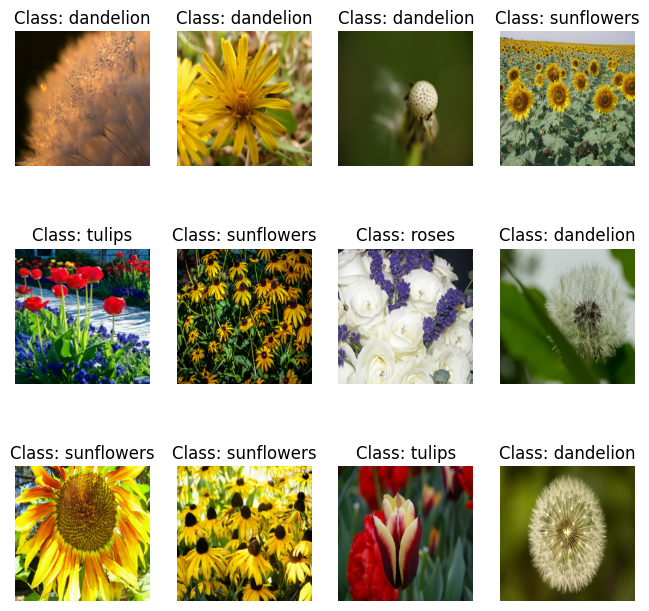

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)  #.repeat()
for X_batch, y_batch in sample_batch:
  for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()


We load the pre-trained Xception model with weights from ImageNet, excluding the top classification layers (`include_top=False`).  
This allows us to reuse its convolutional layers as a powerful feature extractor.

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)


We use a two-phase training strategy:

1. **Freeze the base model** (pretrained Xception) to preserve learned feature representations.
2. **Train only the new classification head**, which starts with random weights.
3. Once the head is trained and stable, we **unfreeze the base model** and fine-tune the entire network with a low learning rate.


Freezing base model layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

We extend the base model by adding:
- a `GlobalAveragePooling2D` layer to flatten feature maps into a vector
- a `Dense` layer with `softmax` activation to predict class probabilities

The new model combines the input from Xception with our custom output head using the Keras Functional API.

In [ ]:
from tensorflow import keras
#from tensorflow.keras import layers, models

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)

model = models.Model(inputs=base_model.input, outputs=output)

We compile the extended model using:
- `sparse_categorical_crossentropy` as the loss function (since class labels are integers),
- the `Adam` optimizer for efficient training,
- and `accuracy` as the evaluation metric.

Next, we train the model for 5 epochs using the prepared training and validation datasets.  
At this point, only the custom classification head is being trained, while the base model remains frozen.

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 767s 9s/step - accuracy: 0.6491 - loss: 0.9750 - val_accuracy: 0.8131 - val_loss: 0.4944
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 813s 9s/step - accuracy: 0.8783 - loss: 0.3865 - val_accuracy: 0.8548 - val_loss: 0.4293
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 766s 9s/step - accuracy: 0.9077 - loss: 0.3153 - val_accuracy: 0.8548 - val_loss: 0.3861
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 818s 9s/step - accuracy: 0.9277 - loss: 0.2617 - val_accuracy: 0.8675 - val_loss: 0.3730
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 773s 9s/step - accuracy: 0.9273 - loss: 0.2369 - val_accuracy: 0.8566 - val_loss: 0.3642


After training the classification head, we now unfreeze all layers in the base Xception model (`layer.trainable = True`)  
to allow fine-tuning of the entire network.

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

We recompile the model using a **very low learning rate (`1e-4`)**,  (defualt value used before is 1e-3),
which ensures that the pretrained layers are adjusted gradually and not disrupted too much by the newly added head.

The full model is then trained for **3 epochs** using the same training and validation datasets.
This step improves the model's performance by allowing small refinements across all layers.

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

model.fit(train_set, validation_data=valid_set, epochs=3)

37/86 ━━━━━━━━━━━━━━━━━━━━ 23:12 28s/step - accuracy: 0.8097 - loss: 0.6222

KeyboardInterrupt: 

We evaluate the trained model on all three datasets: training, validation, and test.  

In [ ]:
acc_train = model.evaluate(train_set, verbose=0)[1]
acc_valid = model.evaluate(valid_set, verbose=0)[1]
acc_test  = model.evaluate(test_set,  verbose=0)[1]

We display the final accuracy values for training, validation, and test sets, each rounded to four decimal places.
This allows us to compare generalization and detect overfitting.

In [ ]:
print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (valid): {acc_valid:.4f}")
print(f"Accuracy (test):  {acc_test:.4f}")

The final model is saved in Keras format (`.keras`), and the accuracy scores are stored in a `.pkl` file using `pickle`.  
This allows later reuse without retraining and makes it easy to load evaluation results.

In [ ]:
import pickle

with open("xception_acc.pkl", "wb") as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)

model.save("xception_flowers.keras")

The Xception-based model was successfully trained using transfer learning in two phases.  
In the first phase, only the custom classification head was trained, while the base Xception layers remained frozen.  
In the second phase, we unfroze all layers and fine-tuned the entire model using a low learning rate.

Thanks to the use of pretrained convolutional layers, the model converged quickly and achieved **excellent performance**.  
After 8 total epochs (5+3), the model reached:
- Training accuracy: **~98%**
- Validation accuracy: **~88%**
- Test accuracy: **~86%**

This result confirms that transfer learning significantly improves generalization and training efficiency.  
Slight overfitting is still observable, but the gap between training and test performance remains acceptable.